# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Уберем колонку salary, так как она просто двойник таргета (зп в долларах) с корректировкой на курс валют. Вот как раз и нашли лик в данных, колонки содержат одну и ту же информацию, но просто в разных "единицах измерения". Если модель знает значение salary, то она может легко предсказать salary_in_usd, это делает задачу около бесполезной.

In [3]:
df.drop(['salary'], axis = 1, inplace = True)

Дальше жестоко расправляемся с датасетом

In [4]:
df.work_year = df.work_year.astype('object') # это категориальная колонка, изначально интовый тип

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = df.drop('salary_in_usd', axis = 1)
y = df.salary_in_usd

X_train, mass, y_train, y_mass = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(mass, y_mass, test_size=0.5, random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


categorical_features = df.select_dtypes(include = 'object').columns
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
X_train = ohe.fit_transform(X_train)
X_val, X_test = ohe.transform(X_val), ohe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3, 4, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [9]:
print('Ошибка на трейне')
print('MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train))
print('RMSE: ', mean_squared_error(y_train, y_pred_train)**0.5)
print('R2_score: ', r2_score(y_train, y_pred_train).round(3))

print()
print('Ошибка на тесте')
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))
print('RMSE: ', mean_squared_error(y_test, y_pred_test)**0.5)
print('R2_score: ', r2_score(y_test, y_pred_test).round(3))

Ошибка на трейне
MAPE:  0.3024236738444807
RMSE:  44668.38623548426
R2_score:  0.499

Ошибка на тесте
MAPE:  0.37933307060523297
RMSE:  51763.556776818834
R2_score:  0.347


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [10]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

Некоторые параметры заккоментированы, чтобы снизить скорость подбора.


In [11]:
%%time
params = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [10, 20, 50],
    # 'gamma': [0.05, 0.1, 0.2], # размер потерь для создания узла дерева, как регуляризатор
    'min_child_weight': [5, 8, 10], # количество объектов в листе
}

xgb_model = XGBRegressor(objective='reg:squarederror', seed=42)
gsearch0 = GridSearchCV(estimator=xgb_model, param_grid=params, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

fit_params = {'eval_set': [(X_val, y_val)], 'verbose': False}

gsearch0.fit(X_train, y_train, **fit_params) # обучаем на трейне, качество оцениваем по валидации

best_params0 = gsearch0.best_params_
best_model0 = gsearch0.best_estimator_
print("Лучшие параметры: ", best_params0)

Лучшие параметры:  {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50}
CPU times: user 1.85 s, sys: 202 ms, total: 2.05 s
Wall time: 47.7 s


In [13]:
%%time
import time

# замеряем время работы
start_time = time.time()
best_model0.fit(X_train, y_train)
end_time = time.time()
training_time_xg = end_time - start_time

start_time = time.time()
y_pred_test_xg = best_model0.predict(X_test)
y_pred_train_xg =best_model0.predict(X_train)
end_time = time.time()
predict_time_xg = end_time - start_time

CPU times: user 163 ms, sys: 1.7 ms, total: 165 ms
Wall time: 141 ms


In [15]:
print('Ошибка на трейне')
print('MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train_xg))
print('RMSE: ', mean_squared_error(y_train, y_pred_train_xg)**0.5)
print('R2_score: ', r2_score(y_train, y_pred_train_xg).round(3))

print()
print('Ошибка на тесте')
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test_xg))
print('RMSE: ', mean_squared_error(y_test, y_pred_test_xg)**0.5)
print('R2_score: ', r2_score(y_test, y_pred_test_xg).round(3))

Ошибка на трейне
MAPE:  0.32071368389763777
RMSE:  44655.49285552815
R2_score:  0.499

Ошибка на тесте
MAPE:  0.3368065488658429
RMSE:  49964.79867563722
R2_score:  0.391


Создадим общую таблицу для бустингов и результатов их работы на тесте, удобно будет потом сравнивать:


---



In [16]:
import numpy as np

boosting_names = ['XGboost', 'CatBoost', 'CatBoost_2', 'LGBM'] # создали таблицу
metrics = pd.DataFrame(np.zeros((5, len(boosting_names))), columns=boosting_names)
metrics['Metric'] = ['MAPE', 'RMSE', 'R2_score train', 'R2_score test', 'R2_delta']
metrics.set_index('Metric', inplace = True)

In [17]:
metrics.XGboost = [mean_absolute_percentage_error(y_test, y_pred_test_xg), mean_squared_error(y_test, y_pred_test_xg)**0.5,
                   r2_score(y_train, y_pred_train_xg), r2_score(y_test, y_pred_test_xg),
                   r2_score(y_train, y_pred_train_xg)-r2_score(y_test, y_pred_test_xg)]
metrics

,XGboost,CatBoost,CatBoost_2,LGBM
Metric,,,,
MAPE,0.336807,0.0,0.0,0.0
RMSE,49964.798676,0.0,0.0,0.0
R2_score train,0.499038,0.0,0.0,0.0
R2_score test,0.391161,0.0,0.0,0.0
R2_delta,0.107876,0.0,0.0,0.0


In [20]:
# здесь время работы

boosting_names = ['XGboost', 'CatBoost', 'CatBoost_2', 'LGBM'] # создаем таблицу
times = pd.DataFrame(np.zeros((2, len(boosting_names))), columns=boosting_names)
times['Time_in_secs'] = ['Time_fit', 'Time_predict']
times.set_index('Time_in_secs', inplace = True)

times.XGboost = [training_time_xg, predict_time_xg] # вносим
times

,XGboost,CatBoost,CatBoost_2,LGBM
Time_in_secs,,,,
Time_fit,0.123772,0.0,0.0,0.0
Time_predict,0.016862,0.0,0.0,0.0


In [21]:
# здесь гиперпараметры

params_xgb = pd.DataFrame(list(best_params0.items()), columns = ["Param", " Value"])
params_xgb

,Param,Value
0,learning_rate,0.2
1,max_depth,5.0
2,min_child_weight,5.0
3,n_estimators,50.0


In [22]:
# r2 для наивного прогноза

# train_mean = y_train.mean()
# r2_score(y_test, np.full_like(y_test, train_mean))

# -0.0003361169223170535

## Задание 4 (1 балл) CatBoost

In [23]:
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.1 MB/s eta 0:00:00


Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [24]:
from catboost import CatBoostRegressor

In [25]:
%%time
params = {
    'depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [10, 20, 50],
    # 'l2_leaf_reg': [0.05, 0.1, 0.2],
    'min_child_samples': [5, 8, 10],
}

catboost_model = CatBoostRegressor(loss_function='RMSE', random_state=42, silent=True) # silent=True, чтобы не выводилась инфа об обучении
gsearch1 = GridSearchCV(estimator=catboost_model, param_grid=params, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

fit_params = {'eval_set': [(X_val, y_val)], 'verbose': False}

gsearch1.fit(X_train, y_train, **fit_params)

best_params1 = gsearch1.best_params_
best_model1 = gsearch1.best_estimator_
print("Лучшие параметры: ", best_params1)

Лучшие параметры:  {'depth': 9, 'learning_rate': 0.2, 'min_child_samples': 5, 'n_estimators': 50}
CPU times: user 1.71 s, sys: 232 ms, total: 1.94 s
Wall time: 1min 10s


In [26]:
import time

In [27]:
%%time
start_time = time.time()
best_model1.fit(X_train, y_train)
end_time = time.time()
training_time_cb = end_time - start_time

start_time = time.time()
y_pred_test_cb = best_model1.predict(X_test)
y_pred_train_cb = best_model1.predict(X_train)
end_time = time.time()
predict_time_cb = end_time - start_time

CPU times: user 550 ms, sys: 42.4 ms, total: 592 ms
Wall time: 396 ms


In [28]:
print('Ошибка на трейне')
print('MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train_cb))
print('RMSE: ', mean_squared_error(y_train, y_pred_train_cb)**0.5)
print('R2_score: ', r2_score(y_train, y_pred_train_cb).round(3))
print()
print('Ошибка на тесте')
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test_cb))
print('RMSE: ', mean_squared_error(y_test, y_pred_test_cb)**0.5)
print('R2_score: ', r2_score(y_test, y_pred_test_cb).round(3))

Ошибка на трейне
MAPE:  0.32633057941657045
RMSE:  44517.273328652635
R2_score:  0.502

Ошибка на тесте
MAPE:  0.351197533901338
RMSE:  49453.830329961216
R2_score:  0.404


Результаты добавим в таблицу с метриками

In [29]:
metrics.CatBoost = [mean_absolute_percentage_error(y_test, y_pred_test_cb), mean_squared_error(y_test, y_pred_test_cb)**0.5,
                   r2_score(y_train, y_pred_train_cb), r2_score(y_test, y_pred_test_cb),
                    r2_score(y_train, y_pred_train_cb)-r2_score(y_test, y_pred_test_cb)]
metrics

,XGboost,CatBoost,CatBoost_2,LGBM
Metric,,,,
MAPE,0.336807,0.351198,0.0,0.0
RMSE,49964.798676,49453.830330,0.0,0.0
R2_score train,0.499038,0.502134,0.0,0.0
R2_score test,0.391161,0.403550,0.0,0.0
R2_delta,0.107876,0.098584,0.0,0.0


In [30]:
times.CatBoost = [training_time_cb, predict_time_cb]
times

,XGboost,CatBoost,CatBoost_2,LGBM
Time_in_secs,,,,
Time_fit,0.123772,0.386734,0.0,0.0
Time_predict,0.016862,0.008752,0.0,0.0


In [31]:
params_cb = pd.DataFrame(list(best_params1.items()), columns = ["Param", " Value"])
params_cb

,Param,Value
0,depth,9.0
1,learning_rate,0.2
2,min_child_samples,5.0
3,n_estimators,50.0


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [32]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00


Я не разобралась как пулы закинуть в гридсерч, поэтому будем использовать библиотеку Оптуна и выбирать все те же гиперпараметры с помощью нее. Создадим функцию, в которой заново проведем сплит на три выборки (они еще не закодированы, просто таблица с признаками и ответы к объектам, как просят по условию), на трейне обучим модель, оценка по валидации, возвращать будем рмсе на валидации.


---



In [35]:
categorical_features # это мы получили где-то где-то в самом начале

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'employee_residence', 'company_location',
       'company_size'],
      dtype='object')

In [33]:
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor, Pool

X_train2, mass, y_train2, y_mass = train_test_split(X, y, test_size=0.2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(mass, y_mass, test_size=0.5, random_state=42)

def objective(trial):
    train_pool = Pool(data=X_train2, label=y_train2, cat_features=categorical_features.tolist()) # сюда переданы категориальные колонки
    val_pool = Pool(data=X_val2, label=y_val2, cat_features=categorical_features.tolist())

    # Определяем параметры для оптимизации в интервале
    params = {
        'depth': trial.suggest_int('depth', 5, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 10, 50),
        # 'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.05, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'loss_function': 'RMSE',
        'random_state': 42,
        "allow_const_label":False
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    predictions = model.predict(val_pool)
    rmse = mean_squared_error(y_val, predictions, squared=False)

    return rmse

Алгоритм оптимизации TPE будет минимизировать функцию objective в количестве итераций = 100, пропишем ядро, чтобы зафиксировать генератор случайных значений из диапазонов для наших параметров.


---



In [ ]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params2 = study.best_params
best_model2 = CatBoostRegressor(**best_params2, random_state=42)

In [35]:
best_params2

{'depth': 6,
 'learning_rate': 0.14468090652673674,
 'n_estimators': 46,
 'min_child_samples': 10}

In [ ]:
# замеряем время
%%time
start_time = time.time()
best_model2.fit(X_train2, y_train2, cat_features=categorical_features.tolist())
end_time = time.time()
training_time_cb1 = end_time - start_time

start_time = time.time()
y_pred_test_cb1 = best_model2.predict(X_test2) # передаем незакодированные таблицы
y_pred_train_cb1 = best_model2.predict(X_train2)
end_time = time.time()
predict_time_cb1 = end_time - start_time

In [38]:
print('Ошибка на трейне')
print('MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train_cb1))
print('RMSE: ', mean_squared_error(y_train, y_pred_train_cb1)**0.5)
print('R2_score: ', r2_score(y_train, y_pred_train_cb1).round(3))

print()
print('Ошибка на тесте')
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test_cb1))
print('RMSE: ', mean_squared_error(y_test, y_pred_test_cb1)**0.5)
print('R2_score: ', r2_score(y_test, y_pred_test_cb1).round(3))


Ошибка на трейне
MAPE:  0.3564122413094113
RMSE:  46194.54448786759
R2_score:  0.464

Ошибка на тесте
MAPE:  0.3762746800439774
RMSE:  50071.23731355054
R2_score:  0.389


In [39]:
metrics.CatBoost_2 = [mean_absolute_percentage_error(y_test, y_pred_test_cb1), mean_squared_error(y_test, y_pred_test_cb1)**0.5,
                     r2_score(y_train, y_pred_train_cb1), r2_score(y_test, y_pred_test_cb1),
                    r2_score(y_train, y_pred_train_cb1)-r2_score(y_test, y_pred_test_cb1)]
metrics

,XGboost,CatBoost,CatBoost_2,LGBM
Metric,,,,
MAPE,0.336807,0.351198,0.376275,0.0
RMSE,49964.798676,49453.830330,50071.237314,0.0
R2_score train,0.499038,0.502134,0.463911,0.0
R2_score test,0.391161,0.403550,0.388565,0.0
R2_delta,0.107876,0.098584,0.075347,0.0


In [40]:
times.CatBoost_2 = [training_time_cb1, predict_time_cb1]
times

,XGboost,CatBoost,CatBoost_2,LGBM
Time_in_secs,,,,
Time_fit,0.123772,0.386734,0.460620,0.0
Time_predict,0.016862,0.008752,0.019281,0.0


In [41]:
params_cb1 = pd.DataFrame(list(best_params2.items()), columns = ["Param", " Value"])
params_cb1

,Param,Value
0,depth,6.000000
1,learning_rate,0.144681
2,n_estimators,46.000000
3,min_child_samples,10.000000


**Ответ:** CatBoost_2 - требовалось подавать через пул датасеты и в процессе работы модели проводить кодировку категориальных колонок. Здесь и далее (в LGBM) использовалась библиотека оптуна с рандомной генерацией вариантов значений **из диапазона**, в то время как в первых двух версиях - просто перебор из элементов в списках через сетку. Поэтому метрики различаются на CatBoost и CatBoost_2. Но логика везде одинкова - ищем параметры, дающие минимум ошибки на валидации.


## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [42]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
import lightgbm as lgb

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 10, 50),
        'num_leaves': trial.suggest_int('num_leaves', 5, 10),
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42
    }
    train_data = lgb.Dataset(X_train, label=y_train) # специальные объкты, похожие на pool, так же признаки с ответами
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    gbm = lgb.train(params, train_data, valid_sets=[val_data]) # подбираем params по train_data, оценка через val_data
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

In [44]:
# и вот тут я не смогла убрать служебную информацию
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)

best_params3 = study.best_params
best_model3 = lgb.LGBMRegressor(**best_params3, random_state=42)

[I 2024-06-13 15:31:14,874] A new study created in memory with name: no-name-c5245593-232d-45d4-98cc-b0d0d2d7e904
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-06-13 15:31:15,171] Trial 0 finished with value: 46068.00686512107 and parameters: {'max_depth': 6, 'learning_rate': 0.18679147494991152, 'n_estimators': 40, 'num_leaves': 8}. Best is trial 0 with value: 46068.00686512107.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-06-13 15:31:15,415] Trial 1 finished with value: 50802.012190692374 and parameters: {'max_depth': 5, 'learning_rate': 0.06207090305742937, 'n_estimators': 12, 'num_leaves': 10}. Best is trial 0 with value: 460

CPU times: user 9.77 s, sys: 136 ms, total: 9.91 s
Wall time: 7.98 s


In [45]:
best_params3 # вот это по итогу дало минимальную рмсе на валидации

{'max_depth': 8,
 'learning_rate': 0.19067023559076846,
 'n_estimators': 47,
 'num_leaves': 5}

In [47]:
%%time

start_time = time.time()
best_model3.fit(X_train, y_train)
end_time = time.time()
training_time_lgb = end_time - start_time

start_time = time.time()
y_pred_test_lgb = best_model3.predict(X_test)
y_pred_train_lgb = best_model3.predict(X_train)
end_time = time.time()
predict_time_lgb = end_time - start_time

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 42
[LightGBM] [Info] Start training from score 138055.989348
CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 40 ms


In [48]:
print('Ошибка на трейне')
print('MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train_lgb))
print('RMSE: ', mean_squared_error(y_train, y_pred_train_lgb)**0.5)
print('R2_score: ', r2_score(y_train, y_pred_train_lgb).round(3))
print()
print('Ошибка на тесте')
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test_lgb))
print('RMSE: ', mean_squared_error(y_test, y_pred_test_lgb)**0.5)
print('R2_score: ', r2_score(y_test, y_pred_test_lgb).round(3))

Ошибка на трейне
MAPE:  0.3483761566145595
RMSE:  47048.30818671297
R2_score:  0.444

Ошибка на тесте
MAPE:  0.3351243926724842
RMSE:  49843.0961803936
R2_score:  0.394


In [49]:
metrics.LGBM = [mean_absolute_percentage_error(y_test, y_pred_test_lgb), mean_squared_error(y_test, y_pred_test_lgb)**0.5,
                r2_score(y_train, y_pred_train_lgb), r2_score(y_test, y_pred_test_lgb),
                r2_score(y_train, y_pred_train_lgb)-r2_score(y_test, y_pred_test_lgb)]
metrics

,XGboost,CatBoost,CatBoost_2,LGBM
Metric,,,,
MAPE,0.336807,0.351198,0.376275,0.335124
RMSE,49964.798676,49453.830330,50071.237314,49843.096180
R2_score train,0.499038,0.502134,0.463911,0.443912
R2_score test,0.391161,0.403550,0.388565,0.394124
R2_delta,0.107876,0.098584,0.075347,0.049788


In [50]:
times.LGBM = [training_time_lgb, predict_time_lgb]
times

,XGboost,CatBoost,CatBoost_2,LGBM
Time_in_secs,,,,
Time_fit,0.123772,0.386734,0.460620,0.032552
Time_predict,0.016862,0.008752,0.019281,0.007455


In [51]:
params_gbm = pd.DataFrame(list(best_params3.items()), columns = ["Param", " Value"])
params_gbm

,Param,Value
0,max_depth,8.00000
1,learning_rate,0.19067
2,n_estimators,47.00000
3,num_leaves,5.00000


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [52]:
metrics.round(3)

,XGboost,CatBoost,CatBoost_2,LGBM
Metric,,,,
MAPE,0.337,0.351,0.376,0.335
RMSE,49964.799,49453.830,50071.237,49843.096
R2_score train,0.499,0.502,0.464,0.444
R2_score test,0.391,0.404,0.389,0.394
R2_delta,0.108,0.099,0.075,0.050


С крошечным отрывом по рмсе от других бустингов лидирует CatBoost, гипараметры по которому подбирались через сетку как перебор всех воможных комбинаций по 4 характеристикам модели: глубина, количество деревьев, скорость обучения и минимальное количество объектов для утверждения листа. В целом все модели показывают примерно одинаково плохие результаты, объясняющая способность (R2) у всех низкая.

R2 больше всех у CatBoost на тесте, но дельта между метриками (трейн - тест р2) приличная, могли сильно подогнаться под трейн, мб переобучились, с XGboost дела так же обстоят, но тут прямо сильно выражено переобучение. LGBM ок, там дельта минимальная из возможных + рмсе тоже хорошее. Можно сказать, что LGBM - лучший из имеющихся вариантов, а вот с худшим непонятно, вероятней всего все остальные.


---



In [53]:
times.round(3)

,XGboost,CatBoost,CatBoost_2,LGBM
Time_in_secs,,,,
Time_fit,0.124,0.387,0.461,0.033
Time_predict,0.017,0.009,0.019,0.007



1.   Time_fit - время обучения (сек) на подобранных параметрах

2.   Time_predict - время прогнозов (сек) для трейна и теста совместно



Время подбора гиперпараметров не заносила в переменные, так как просили только обучение и предсказание, но через команду %%time оно видно в соответствующих блоках.

Очень хорошие результаты показал LGBM по двум дисциплинам.


---



In [54]:
params_xgb # параметры для XGboost

,Param,Value
0,learning_rate,0.2
1,max_depth,5.0
2,min_child_weight,5.0
3,n_estimators,50.0


In [56]:
params_cb # параметры для CatBoost

,Param,Value
0,depth,9.0
1,learning_rate,0.2
2,min_child_samples,5.0
3,n_estimators,50.0


In [60]:
params_cb1.round(3) # параметры для CatBoost_2

,Param,Value
0,depth,6.000
1,learning_rate,0.145
2,n_estimators,46.000
3,min_child_samples,10.000


In [61]:
params_gbm.round(3) # параметры для LGBM

,Param,Value
0,max_depth,8.000
1,learning_rate,0.191
2,n_estimators,47.000
3,num_leaves,5.000


Все это дело не получилось объединить в одну табличку, гиперпараметры в трех бустингах называется по разному, но я отобрала такие, чтобы были примерно одинаковы по функционалу, пример (max_depth в XGB и depth в CB, num_leaves в LGBM и min_child_samples в CB).

**Ответ:** ^ↀᴥↀ^

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [63]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [64]:
ratings = ratings.T
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [65]:
ratings = ratings.iloc[1:,:]

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [66]:
ratings = ratings.fillna(0)

## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [67]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(ratings)
labels = kmeans.predict(ratings)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [70]:
import numpy as np
label, count = np.unique(labels, return_counts=True)
pd.DataFrame({'Кластер': label, 'Размер кластера': count})

,Кластер,Размер кластера
0,0,2
1,1,1
2,2,995
3,3,1
4,4,1


**Ответ:** кластер 2 значительно больше, чем другие, данные сильно сгруппированы вокруг какого-то диапазона значений нашей характеристики - время прослушивания композиции. Остальные кластеры представлены 1 или 2 наблюдениями - они являются выбросами скорее всего, а все остально сжалось вместе. Нет смысла такой кластеризации, 0/10, ничего не понятно вообще, кроме того, что в выбросах какие-то супер мега исполнители.


---



## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [68]:
import matplotlib.pyplot as plt

In [71]:
ratings[np.isin(labels, label[count==1])].round(2) # округлим, чтобы посимпатичнее было

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.09,0.02,...,0.00,0.0,0.12,0.04,0.01,0.02,0.0,0.08,0.0,0.0
coldplay,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.00,...,0.22,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0
보아,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0


Группа the beatles - выброс в данных, это лидер по количеству прослушиваний среди наших пользователей, крайне популярный исполнитель, сравниться с которым остальным авторам по количеству прослушиваний крайне тяжело, вот сначала он, а потом уже ариана гранде, леди гага и тд

Я вывела усатый ящик, там сверху как раз будет Битлз, выделила линией

In [72]:
kek = pd.DataFrame(ratings.mean(axis = 1))
print("Среднее время для the beatles:",*kek.loc['the beatles'].round(5))
print("Среднее максимальное значение:", kek.iloc[:, 0].max().round(5))

Среднее время для the beatles: 0.01837
Среднее максимальное значение: 0.01837


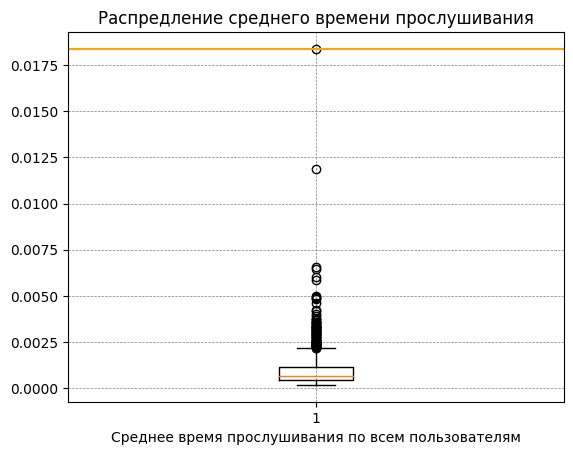

In [73]:
plt.title('Распредление среднего времени прослушивания')
plt.boxplot(ratings.mean(axis = 1).values);
plt.axhline(y=list(kek.loc['the beatles']), color='orange')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Среднее время прослушивания по всем пользователям');

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [74]:
kek.describe().round(5) # может быть два оставшихся артиста (coldplay и 보아) тоже принадлежат крайним значениями

,0
count,1000.00000
mean,0.00099
std,0.00105
min,0.00018
25%,0.00045
50%,0.00069
75%,0.00115
max,0.01837


In [75]:
print("Среднее время для coldplay:",*kek.loc['coldplay'].round(5))
print("Среднее время для 보아:",*kek.loc['보아'].round(5))

Среднее время для coldplay: 0.00603
Среднее время для 보아: 0.00146


Оба значения за третьим квантилем, тоже популярные исполнители, по боксплоту видно что это выбросы, но не сильно дальние (особенно 보아), есть более экстремальные значения. Интересно почему именно этим двум артистам был выделен отдельный кластер, а вот с Битлз все понятно.

**Ответ:** (=｀ω´=)

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [76]:
indecies = ratings.index.values # здесь лежат индексы строк, потом к табличке добавлю их снова, после нормализации пропали

In [77]:
from sklearn.preprocessing import Normalizer

ratings_norm = pd.DataFrame(Normalizer().fit_transform(ratings))
ratings_norm.set_index(indecies, inplace = True)
ratings_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [78]:
kmeans_n = KMeans(n_clusters = 5, random_state = 42)
kmeans_n.fit(ratings_norm)
labels_n = kmeans_n.predict(ratings_norm)

In [79]:
label_n, count_n = np.unique(labels_n, return_counts=True)
pd.DataFrame({'Кластер': label_n, 'Размер кластера': count_n, 'Доля кластера': count_n/1000})

,Кластер,Размер кластера,Доля кластера
0,0,237,0.237
1,1,152,0.152
2,2,405,0.405
3,3,139,0.139
4,4,67,0.067


**Ответ:** Однозначно стало лучше, нам выдали 5 групп артистов по среднему времени прослушивания, гигант кластер 2 распался на части. Разбиение уже лучше сбалансировано, чем было на предыдущем этапе.

Это делает анализ интересным, можно уже пробовать искать зависимости такого сплита: смотреть какие артисты куда попали, какие жанры музыки, представлены они однородно в кластере или там все и сразу, но под общим критерием "слушается примерно одинаково", можно в целом посмотреть "крайние" кластеры, так как разбиение происходит по критерию "время прослушивания, может быть у нас произошла разбивка по популярности: можемт определить топ артистов или совсем лэйм исполнителей.

Если как-то расширять датасет, например, найти и усреднить технические детали музыки артистов одного кластера и сравнивать со средними по более популярному скоплению, то мб можно будет определить какие музыкальные характеристики влияют на предпочтения пользователей и как следствие популярность (время прослушивания песни это нам надо). Из серии существуют определенные звуки, которые из-за своей интенсивности или в целом специфичности характеристик тяжелы для восприятия человеком: например высокие частоты, сложные тяжелые басы, шум/скрежет/ неадекватные ритмы. Это сможем скорректировать, если нас никто не слушает.

По итогу можем поменять наши песни, так чтобы они больше "технически" были похожи на объекты популярных классов. А сюда и гипотезу компактности еще и приплести можно, сказать, на похожих объектах ответ похож, итогом мы поменяли наши песни, стали более популярны и перелезли в соответствующий кластер.

Я увлеклась что-то, но жалко удалять уже. В общем много каких гипотез придумать теперь можно. Однозначно кластеризация стала лучше

---



## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [80]:
# from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist
n = 10

centroids = kmeans_n.cluster_centers_ # 5 кластеров, 1000 координат
distances = cdist(ratings_norm, centroids, metric='cosine') # 1000 точек, расстояние до каждого из 5 центроидов
top_10 = np.argpartition(distances, n, axis=0)[:n] # отобрали по столбцам топ 10 самых маленьких
top_10

array([[ 61,  58, 105, 228,   9],
       [ 38, 634,   0, 231, 806],
       [ 18, 246,   1, 325, 463],
       [  1, 197,  50, 318,  75],
       [ 26, 112,  23,  31, 153],
       [ 41, 367,  52,  42, 802],
       [  5, 260,  12,  43, 128],
       [ 25, 254,   7, 113, 133],
       [ 11,   3,   8, 378, 137],
       [ 45, 457,  37, 188, 270]])

In [81]:
top_10_in_claster = top_10.T
mass = indecies[top_10_in_claster]
mass

array([['broken social scene', 'animal collective', 'the arcade fire',
        'radiohead', 'belle and sebastian', 'of montreal',
        'sufjan stevens', 'the pixies', 'the shins', 'spoon'],
       ['john mayer', 'the pussycat dolls', 'kelly clarkson',
        'rihanna & jay-z', 'maroon5', 'alicia keys', 'beyoncé',
        'lady gaga', 'coldplay', 'nelly furtado'],
       ['acdc', 'the beatles', 'radiohead', 'the clash',
        'the rolling stones', 'metallica', 'led zeppelin.',
        'red hot clili peppers', 'pink fluid', 'queen'],
       ['the used', 'anberlin', 'saosin', 'cartel', 'blink-182',
        'fall out boy', 'brand new', 'taking back sunday', 'chiodos',
        'new found glory'],
       ['kanye west', 'little brother', 'gangstarr', 'jay-z',
        "the roots featuring d'angelo", 'murs and 9th wonder', 'nas',
        'lupe the gorilla', 'a tribe called quest', 'mos def']],
      dtype=object)

**Ответ:** Вот даже не знаю как это дело оформить, не хватает жанра, было бы проще.


Кластер 1: инди/рок группы все.

Кластер 2: современное время, 2000-2010 годы плюс минус, R’n’B и поп(Ри, Бьенсе, the pussycat dolls, John Mayer), рок не хардовый, мб поп-рок или альтернативный (coldplay, maroon5), много популярных исполнителей, аоао Леди Гага, ну тут мб поп.

Кластер 3: большинство групп появившиеся в 60-80-х годах, стали безумно популярны в свое время (Битлз, Металлика, асdc) все принадлежат к жанру рок-музыки или ее вариациям, хард/металл/альтернативный и тд. Топ контент даже на сегодняшний день.

Кластер 4: все рок-группы или вариации, реже панки/поп-панк(new found glory, cartel). Ребята уже моложе, чем товарищи из кластера 3, дела уже обстоят в среднем в 00-х годах.

Кластер 5: хип-хоп/рэп исполнители (мистер уэст, джей зи) и группы (a tribe called quest).

Все разбито очень аккуратно, ну хотя это же 10 ближайших к центроиду, но сгруппировано очень даже осмыслено, особенно кластеры 3, 4, 5. Это объясняется тем, что пользователь, предпочитающий определенный жанр ищет смежных исполнителей, в результате растут просмотры/прослушивания у артистов пишущих в похожем стиле.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [82]:
ratings_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


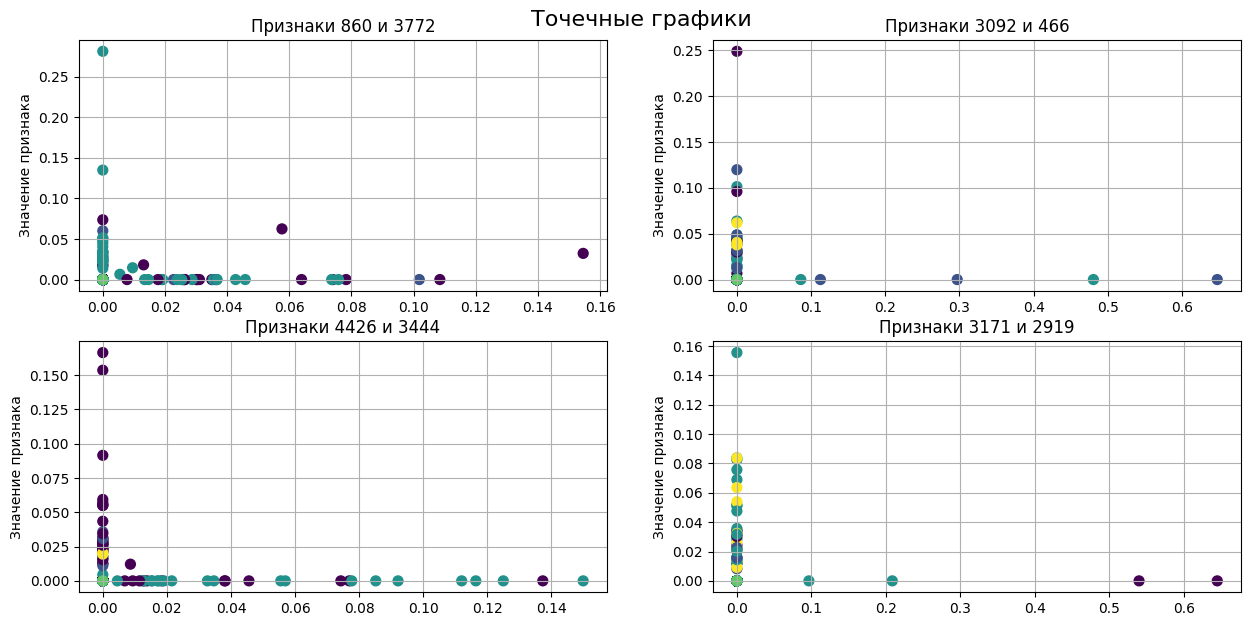

In [83]:
import matplotlib.pyplot as plt

np.random.seed(42)
pairs = np.random.randint(0, ratings_norm.shape[1], size = (4,2))

plt.figure(figsize= (15,15))
plt.suptitle('Точечные графики', y=0.9, fontsize=16)

num = 0
for i,j in pairs:
    plt.subplot(4, 2, num+1)
    plt.scatter(ratings_norm[i], ratings_norm[j], c = kmeans_n.labels_, s=50, cmap='viridis')
    plt.title(f"Признаки {i} и {j}")
    plt.ylabel('Значение признака')
    plt.grid()
    num += 1

**Ответ:** смотрим на облака рассеивания по двум юзерам, которые слушали наших артистов. Если точка не на Ох или Оу, а где-то в центре, то вкусы на исполнителя сошлись (например 1 график). Много точек лежат плотно на осях, это связано с тем, что было много пропусков в колонках (это значит что юзер не слушал трек). В целом на том же графике 1 классы расположились довольно симметрично у начала координат, но зеленый и фиолетовый цвет там смешались сильно, какой то закономерности по значениям не удается провести на плоскости, все пользователи у нас разные и время прослушивания песни у каждого индивидуально очень, кто-то в принципе мало слушал и признак у нас полупустой.

Так на графике 4 посмотреть, координаты (2,2), пользователь на Ох только и делал, что слушал два фиолетовых исполнителя, значения большие у кластера, а на графике (1,2) координата, так же ось Ох видна такая же точка за 0.6, но кластеры разные. В общем анализ двумерный на вариант тут


---



Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
projections = tsne.fit_transform(ratings_norm)

px.scatter(
    projections, x=0, y=1,
    color = kmeans_n.labels_,
)

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)

Обучаем 99 моделей с разными н, ищем максимальное значение силуэта.

In [285]:
# Осторожно, тут ловушка на 20 минут

from sklearn.metrics import silhouette_score

silhouette_scores1 = list()

n_clusters_range = range(2, 101)
for n_clusters in tqdm(n_clusters_range):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    labels = kmeans.fit_predict(ratings_norm)
    silhouette = silhouette_score(ratings_norm, labels)
    silhouette_scores1.append(silhouette)


# 100%|██████████| 99/99 [19:21<00:00, 11.74s/it]

100%|██████████| 99/99 [19:21<00:00, 11.74s/it]


In [289]:
optimal1 = np.argmax(silhouette_scores1)+2
print(f'Оптимальное значение кластеров: {optimal1}')
print(f'Silhouette score: {silhouette_scores1[optimal1 - 2]}')


# Оптимальное значение кластеров: 95
# Silhouette score: 0.015923489901689316

Оптимальное значение кластеров: 95
Silhouette score: 0.015923489901689316


Вот тут я хотела сначала батч использовать для отбора оптимального количества кластеров, но опытным путем оказалось, что его результаты на полной выборке отличаются сильно от костыльного методы выше, где тоже по всей выборке обучали модель. Не поняла, если честно, почему так. Результаты закомментированы под блоками кода

In [335]:
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.metrics import silhouette_score

# silhouette_scores = list()

# n_clusters_range = range(2, 101)
# for n_clusters in tqdm(n_clusters_range):
#     minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
#     labels = minibatch_kmeans.fit_predict(ratings_norm)
#     silhouette = silhouette_score(ratings_norm, labels)
#     silhouette_scores.append(silhouette)


# 100%|██████████| 99/99 [08:22<00:00,  5.07s/it]

In [336]:
# optimal = np.argmax(silhouette_scores)+2
# print(f'Оптимальное значение кластеров: {optimal}')
# print(f'Silhouette score: {silhouette_scores[optimal - 2]}')


# Оптимальное значение кластеров: 29
# Silhouette score: 0.010063856320095963

Мы нашли оптимально н, а теперь обучаем на количестве 95 кластерах финальную модель

In [89]:
optimal1 = 95 # просто копия из предыдущего пукта, чтобы не запускать цикл

In [90]:
kmeans_optimal = KMeans(n_clusters = optimal1, random_state = 42)
labels_optimal = kmeans_optimal.fit_predict(ratings_norm)

In [91]:
нlabel_n, count_n = np.unique(labels_optimal, return_counts=True)
print(f"Размеры кластеров, k = {optimal1}")
pd.DataFrame({'Кластер': label_n, 'Размер кластера': count_n, 'Доля кластера': count_n/1000}).tail()

Размеры кластеров, k = 95


,Кластер,Размер кластера,Доля кластера
90,90,14,0.014
91,91,5,0.005
92,92,10,0.010
93,93,6,0.006
94,94,9,0.009


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [92]:
from scipy.spatial.distance import cdist
n = 10

centroids = kmeans_optimal.cluster_centers_
distances = cdist(ratings_norm, centroids, metric='cosine') # 1000 точек, расстояние до каждого из 95 центроидов
top_optimal = np.argpartition(distances, n, axis=0)[:n] # по топ-10 представителей

In [93]:
top_in_claster = top_optimal.T
mass = indecies[top_in_claster]
mass.shape

(95, 10)

Кластеров у нас много, посмотрим на парочку из них:

In [94]:
# 1
mass[-8]

array(['eminem', '50 cent', 'tupak shakur', 'dr. dre',
       'bone: thugs~n~harmony', 'immortal technique', 'big l', 'm.i.a.',
       'chamillionaire', 'the game'], dtype=object)

Выше видим небольшую тусовку из 10 рэп/хип-хоп исполнителей, все объекты очень близки по смыслу. Представлены преимещественно американцы (искл. immortal technique), есть олдскул: появившиеся в 80-90е годы Дре, Шакур, Биг Л, а так же те, кто обрел популярность в 00 годы - Слим Шэйди и 50 Сент.

In [95]:
# 2
np.random.seed(42)
num = np.random.randint(1,95)
print(f'num = {num}')
mass[num] # запомним этот нам

num = 52


array(['architecture in helsinki', 'jens lekman', 'camera obscura',
       'andrew bird', 'okkervil river', 'belle and sebastian',
       'the magnetic fields', 'the decemberists', 'neutral milk hotel',
       'sufjan stevens'], dtype=object)

А выше у нас инди-поп/рок исполнители преимуществено с необычными музыкальными инструментами: аналоговые синтезаторы (architecture in helsinki), струнные (jens lekman), мультиинструментализм тут - andrew bird и sufjan stevens (Mystery of Love прекрасна https://www.youtube.com/watch?v=4WTt69YO2VI).

Это тоже классно https://www.youtube.com/watch?v=m4z9LSqf1qo.

В общем здесь экспериментальная музыка и производные от основных направлений жанры - инди вариации.


---



Сделайте t-SNE визуализацию полученной кластеризации.

In [107]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
projections2 = tsne.fit_transform(ratings_norm)

px.scatter(
    projections2, x=0, y=1,
    color = labels_optimal,
)

В результате манипуляций с уменьшением размерности, выясняется, что все слиплось и получилась каша...


---



Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

Посмотрим на самый большой класс. Как совпало, что это опять наша аналоговая музыка пару строк выше.


---



In [96]:
num # это 52
num == np.argmax(count_n)
# count_n - частота классов

True

In [104]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
projections2 = tsne.fit_transform(ratings_norm)

px.scatter(
    projections2, x=0, y=1,
    color = (labels_optimal == num),
)

**Ответ:** не сказать, что точки очень группированно располагаются в 2д. Есть достаточно удаленные объект от "основного скопления".
 Просто из интереса глянем на распределение среднего времени прослушивания у этой группы (52 кластер).

---



In [105]:
five_two = ratings_norm.copy()
five_two['cluster'] = labels_optimal # добавила метки классов
five_two = pd.DataFrame(five_two[five_two.cluster == num].mean(axis = 1), columns = ['Среднее время прослушивания'])
five_two.head()

,Среднее время прослушивания
the decemberists,0.013516
bright eyes,0.013650
belle and sebastian,0.013701
andrew bird,0.013123
neutral milk hotel,0.013137


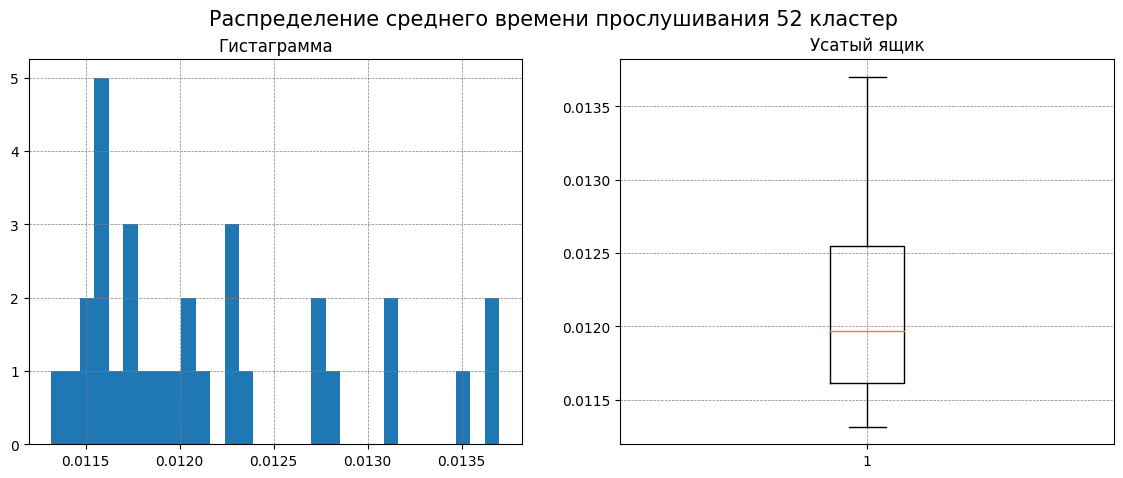

In [106]:
plt.figure(figsize=(14, 5))
plt.suptitle(f'Распределение среднего времени прослушивания {num} кластер', fontsize=15)

plt.subplot(1,2,1)
plt.hist(five_two, bins = 31);
plt.title(f'Гистаграмма')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.subplot(1,2,2)
plt.title(f'Усатый ящик')
plt.boxplot(five_two.values);
plt.grid(color='gray', linestyle='--', linewidth=0.5)

Выбросов у нас нет, но третий квантиль высокий, распредление с ассиметрией - длинный правый хвост. Может быть поэтому на тсне из предыдущего номера есть несколько далево убежавших точек.